In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Load saved data
from google.colab import drive
drive.mount('/content/drive')
data = np.load('/content/drive/My Drive/Github/mtc-device-activation/data/activity-models/e2-general-model.npz', allow_pickle=True)
all_DeviceLocations = data['all_DeviceLocations']
num_samples = data['num_samples']
device_count = data['device_count']
sparsity = data['sparsity']

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-theta.npz", allow_pickle=True)
all_theta = data["all_theta"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-gamma.npz", allow_pickle=True)
all_gamma = data["all_gamma"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-z.npz", allow_pickle=True)
all_z = data["all_z"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-noise.npz", allow_pickle=True)
all_noise = data["all_noise"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-received-signal.npz", allow_pickle=True)
all_received_signal = data["all_received_signal"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-general.npz", allow_pickle=True)
snr_db_array = data["snr_db_array"]
pilot_length_array = data["pilot_length_array"]
M = data["M"]

snr_db_index = 2
snr_db=snr_db_array[snr_db_index]

Mounted at /content/drive


In [3]:
num_samples = 1000
sample_range = range(200, 400)

Sparse Bayesian Learning (SBL)

In [4]:
def sbl_algorithm(theta, y, noise_var, max_iter=500, stopping_criterion=1e-4):
    # Sparse Bayesian Learning (SBL) for Multiple Measurement Vectors (MMV).

    M = y.shape[1]  # Number of antennas (columns of y)

    L = theta.shape[0]  # Pilot Length (rows of theta)
    N = theta.shape[1] # Number of MTDs (columns of theta)

    # Initialize Gamma (covariance matrix of the signal)
    Gamma = np.eye(N) * 0.1  # Initial guess: identity matrix

    # Iterative update process
    for t in range(max_iter):
       # E-Step: Compute the mean (mu_x) and covariance (Sigma_x) of x
        Sigma_y = theta @ Gamma @ theta.conj().T + noise_var * np.eye(L)
        Sigma_y_inv = np.linalg.inv(Sigma_y)
        Sigma_x = Gamma - Gamma @ theta.conj().T @ Sigma_y_inv @ theta @ Gamma
        mu_x = Gamma @ theta.conj().T @ Sigma_y_inv @ y

        # Compute gamma update using the derived formula
        gamma_new = (np.linalg.norm(mu_x, axis=1) ** 2) / M + np.real(np.diag(Sigma_x))

        # Ensure non-negativity for numerical stability
        gamma_new = np.maximum(gamma_new, 1e-8)

        # Check for convergence: if change is below threshold, stop iterations
        if np.linalg.norm(gamma_new - np.diag(Gamma)) < stopping_criterion:
            print(f"Converged after {t+1} iterations")
            break

        # Update Gamma with new values
        Gamma = np.diagflat(gamma_new)

    # Return final estimates
    return mu_x, np.diag(Gamma)


In [5]:
# Placeholder arrays for results
z_res = np.zeros((num_samples, len(pilot_length_array), device_count, M), dtype=np.complex128)  # Z estimates
gamma_res = np.zeros((num_samples, len(pilot_length_array), device_count), dtype=bool)  # Gamma support

hr_res = np.zeros((num_samples, len(pilot_length_array)))         # HR
fr_res = np.zeros((num_samples, len(pilot_length_array)))         # FR
srr_res = np.zeros((num_samples, len(pilot_length_array)))        # SRR
precision_res = np.zeros((num_samples, len(pilot_length_array)))  # Precision
recall_res = np.zeros((num_samples, len(pilot_length_array)))     # Recall
f1_res = np.zeros((num_samples, len(pilot_length_array)))         # F1
nmse_res = np.zeros((num_samples, len(pilot_length_array)))       # NMSE

In [6]:
# Loop through each sample with an outer progress bar
for sample_index in tqdm(sample_range, desc="Processing Samples", position=0):
    gamma = all_gamma[sample_index]  # Ground truth gamma values (true support)
    loc = all_DeviceLocations[sample_index]

    # Loop over each SNR level with an inner progress bar
    for pilot_length_index in tqdm(range(len(pilot_length_array)), desc="Processing Pilot Length Levels", leave=False, position=1):
        pilot_length = pilot_length_array[pilot_length_index]
        theta = all_theta[sample_index, pilot_length_index, :pilot_length]
        received_signal = all_received_signal[sample_index, pilot_length_index, snr_db_index, :pilot_length]
        z = all_z[sample_index]
        snr = 10 ** (snr_db / 10)
        signal_power = np.mean(np.abs(np.matmul(theta, z))**2)
        noise_power = signal_power / snr

        # Apply SBL algorithm for the current sample and Pilot Length
        z_result, gamma_result = sbl_algorithm(theta, received_signal, noise_power)

        # Zero-out results with low gamma values
        z_result[gamma_result <= 0.05] = 0
        z_res[sample_index, pilot_length_index, :, :] = z_result
        gamma_result_bool =  gamma_result > 0.05
        gamma_res[sample_index, pilot_length_index, :] = gamma_result_bool

        # Compute number of active/inactive devices from ground truth
        active_devices = np.sum(gamma == 1)
        inactive_devices = np.sum(gamma == 0)

        # Hit rate: percentage of correctly identified active devices
        hr_res[sample_index, pilot_length_index] = (
            100 * np.sum((gamma_result_bool == 1) & (gamma == 1)) / active_devices if active_devices > 0 else 0
        )

        # False alarm rate: percentage of inactive devices wrongly detected as active
        fr_res[sample_index, pilot_length_index] = (
            100 * np.sum((gamma_result_bool == 1) & (gamma == 0)) / inactive_devices if inactive_devices > 0 else 0
        )

        # Support recovery rate: proportion of correctly identified active devices
        srr_res[sample_index, pilot_length_index] = (
            np.sum((gamma_result_bool == 1) & (gamma == 1)) /
            (np.sum((gamma_result_bool == 1) & (gamma == 0)) + np.sum((gamma_result_bool == 0) & (gamma == 1)) + sparsity)
        )

        # Classification metrics: TP, FP, FN
        TP = np.sum((gamma_result_bool == 1) & (gamma == 1))
        FP = np.sum((gamma_result_bool == 1) & (gamma == 0))
        FN = np.sum((gamma_result_bool == 0) & (gamma == 1))

        # Precision: proportion of predicted active devices that are actually active
        precision_res[sample_index, pilot_length_index] = TP / (TP + FP) if (TP + FP) > 0 else 0

        # Recall: proportion of actual active devices that are correctly identified
        recall_res[sample_index, pilot_length_index] = TP / (TP + FN) if (TP + FN) > 0 else 0

        # F1 Score: harmonic mean of precision and recall
        if (precision_res[sample_index, pilot_length_index] + recall_res[sample_index, pilot_length_index]) > 0:
            f1_res[sample_index, pilot_length_index] = (
                2 * precision_res[sample_index, pilot_length_index] * recall_res[sample_index, pilot_length_index]
                /
                (precision_res[sample_index, pilot_length_index] + recall_res[sample_index, pilot_length_index])
            )
        else:
            f1_res[sample_index, pilot_length_index] = 0

        # Normalized Mean Squared Error: compares estimated and true z vectors for active devices
        nmse_res[sample_index, pilot_length_index] = (
            np.linalg.norm(z[gamma == 1] - z_result[gamma == 1])**2 / np.linalg.norm(z[gamma == 1])**2
        )


Processing Samples:   1%|          | 2/200 [03:28<5:42:39, 103.84s/it]

Converged after 451 iterations



Processing Samples:   7%|▋         | 14/200 [24:32<5:23:34, 104.38s/it]

Converged after 430 iterations



Processing Samples:   8%|▊         | 15/200 [26:18<5:23:24, 104.89s/it]

Converged after 468 iterations



Processing Samples:   8%|▊         | 16/200 [28:02<5:20:41, 104.57s/it]

Converged after 416 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:21<00:16, 16.09s/it]

Converged after 405 iterations



Processing Samples:  10%|█         | 21/200 [36:45<5:11:53, 104.54s/it]

Converged after 473 iterations



Processing Samples:  14%|█▍        | 29/200 [50:55<5:02:34, 106.17s/it]

Converged after 476 iterations



Processing Samples:  16%|█▌        | 31/200 [54:29<4:59:33, 106.35s/it]

Converged after 489 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:26<00:17, 17.94s/it]

Converged after 497 iterations



Processing Samples:  20%|█▉        | 39/200 [1:08:31<4:40:05, 104.38s/it]

Converged after 427 iterations



Processing Samples:  20%|██        | 40/200 [1:10:18<4:40:17, 105.11s/it]

Converged after 493 iterations



Processing Samples:  22%|██▏       | 44/200 [1:17:20<4:32:56, 104.98s/it]

Converged after 445 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:27<00:18, 18.33s/it]

Converged after 496 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:26<00:17, 17.95s/it]

Converged after 476 iterations



Processing Samples:  34%|███▎      | 67/200 [1:58:11<3:56:29, 106.69s/it]

Converged after 467 iterations



Processing Samples:  35%|███▌      | 70/200 [2:03:26<3:47:59, 105.22s/it]

Converged after 401 iterations



Processing Samples:  36%|███▌      | 71/200 [2:05:09<3:44:58, 104.64s/it]

Converged after 423 iterations



Processing Samples:  40%|███▉      | 79/200 [2:19:20<3:34:01, 106.13s/it]

Converged after 431 iterations



Processing Samples:  40%|████      | 80/200 [2:21:03<3:29:57, 104.98s/it]

Converged after 405 iterations



Processing Samples:  43%|████▎     | 86/200 [2:31:40<3:22:08, 106.39s/it]

Converged after 494 iterations



Processing Samples:  46%|████▌     | 91/200 [2:40:27<3:10:56, 105.10s/it]

Converged after 443 iterations



Processing Samples:  50%|█████     | 100/200 [2:56:14<2:54:55, 104.96s/it]

Converged after 454 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:26<00:17, 17.94s/it]

Converged after 464 iterations



Processing Samples:  57%|█████▋    | 114/200 [3:20:56<2:30:21, 104.90s/it]

Converged after 475 iterations



Processing Samples:  58%|█████▊    | 116/200 [3:24:22<2:25:44, 104.10s/it]

Converged after 460 iterations



Processing Samples:  63%|██████▎   | 126/200 [3:41:55<2:09:13, 104.77s/it]

Converged after 473 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:26<00:17, 17.40s/it]

Converged after 428 iterations



Processing Samples:  69%|██████▉   | 138/200 [4:03:18<1:50:47, 107.21s/it]

Converged after 453 iterations



Processing Samples:  72%|███████▏  | 144/200 [4:13:58<1:40:04, 107.22s/it]

Converged after 487 iterations



Processing Samples:  73%|███████▎  | 146/200 [4:17:29<1:35:50, 106.49s/it]

Converged after 499 iterations



Processing Samples:  74%|███████▎  | 147/200 [4:19:14<1:33:30, 105.85s/it]

Converged after 430 iterations



Processing Samples:  74%|███████▍  | 149/200 [4:22:45<1:29:44, 105.57s/it]

Converged after 455 iterations



Processing Samples:  82%|████████▏ | 163/200 [4:47:38<1:05:59, 107.02s/it]

Converged after 497 iterations



Processing Samples:  85%|████████▌ | 170/200 [5:00:11<53:32, 107.09s/it]

Converged after 496 iterations



Processing Samples:  86%|████████▌ | 171/200 [5:01:57<51:37, 106.80s/it]

Converged after 483 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:27<00:17, 17.97s/it]

Converged after 494 iterations



Processing Samples:  89%|████████▉ | 178/200 [5:14:24<38:55, 106.17s/it]

Converged after 448 iterations



Processing Samples:  90%|████████▉ | 179/200 [5:16:11<37:13, 106.37s/it]

Converged after 480 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:24<00:17, 17.22s/it]

Converged after 437 iterations



Processing Samples:  92%|█████████▎| 185/200 [5:26:49<26:30, 106.03s/it]

Converged after 486 iterations



Processing Samples:  93%|█████████▎| 186/200 [5:28:37<24:52, 106.61s/it]

Converged after 498 iterations



Processing Samples:  94%|█████████▎| 187/200 [5:30:25<23:12, 107.14s/it]

Converged after 495 iterations



Processing Samples:  98%|█████████▊| 195/200 [5:44:38<08:51, 106.34s/it]

Converged after 491 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:26<00:17, 17.77s/it]

Converged after 478 iterations



Processing Samples: 100%|█████████▉| 199/200 [5:51:46<01:46, 106.58s/it]

Converged after 470 iterations



Processing Samples: 100%|██████████| 200/200 [5:53:32<00:00, 106.06s/it]


In [7]:
# Compute the average across all samples for each SNR level
avg_hr = np.mean(hr_res, axis=0)         # HR
avg_srr = np.mean(srr_res, axis=0)       # SRR
avg_fr = np.mean(fr_res, axis=0)         # FR
avg_pr = np.mean(precision_res, axis=0)  # Precision
avg_re = np.mean(recall_res, axis=0)     # Recall
avg_f1 = np.mean(f1_res, axis=0)         # F1
avg_nmse = np.mean(nmse_res, axis=0)     # NMSE

# Print average results
print("Avg HR  :", avg_hr)
print("Avg SRR :", avg_srr)
print("Avg FR  :", avg_fr)
print("Avg PR  :", avg_pr)
print("Avg RE  :", avg_re)
print("Avg F1  :", avg_f1)
print("Avg NMSE:", avg_nmse)

Avg HR  : [ 9.05  14.015 18.28  19.675 19.915 19.95 ]
Avg SRR : [0.03993532 0.07506235 0.12534366 0.16022755 0.17389371 0.18197202]
Avg FR  : [0.83710526 0.70210526 0.44052632 0.23631579 0.15657895 0.10421053]
Avg PR  : [0.07286873 0.10348659 0.13873574 0.16406283 0.17504242 0.18273073]
Avg RE  : [0.0905  0.14015 0.1828  0.19675 0.19915 0.1995 ]
Avg F1  : [0.080523   0.11879558 0.15741385 0.17860153 0.18605089 0.19054499]
Avg NMSE: [0.14482526 0.09554573 0.04444937 0.02159305 0.01441665 0.01130514]


In [8]:
np.savez_compressed(
    '/content/drive/My Drive/Github/mtc-device-activation/data/results/e2-results-1000-sbl-snr-db-12-pilot-length-all-set-2.npz',
    z_res=z_res,
    gamma_res=gamma_res,
    hr_res=hr_res,
    fr_res=fr_res,
    srr_res=srr_res,
    precision_res=precision_res,
    recall_res=recall_res,
    f1_res=f1_res,
    nmse_res=nmse_res,
    avg_hr=avg_hr,
    avg_fr=avg_fr,
    avg_srr=avg_srr,
    avg_pr=avg_pr,
    avg_re=avg_re,
    avg_f1=avg_f1,
    avg_nmse=avg_nmse,
    pilot_length_array=pilot_length_array,
    snr_db=snr_db
)

print("All results have been saved")

All results have been saved


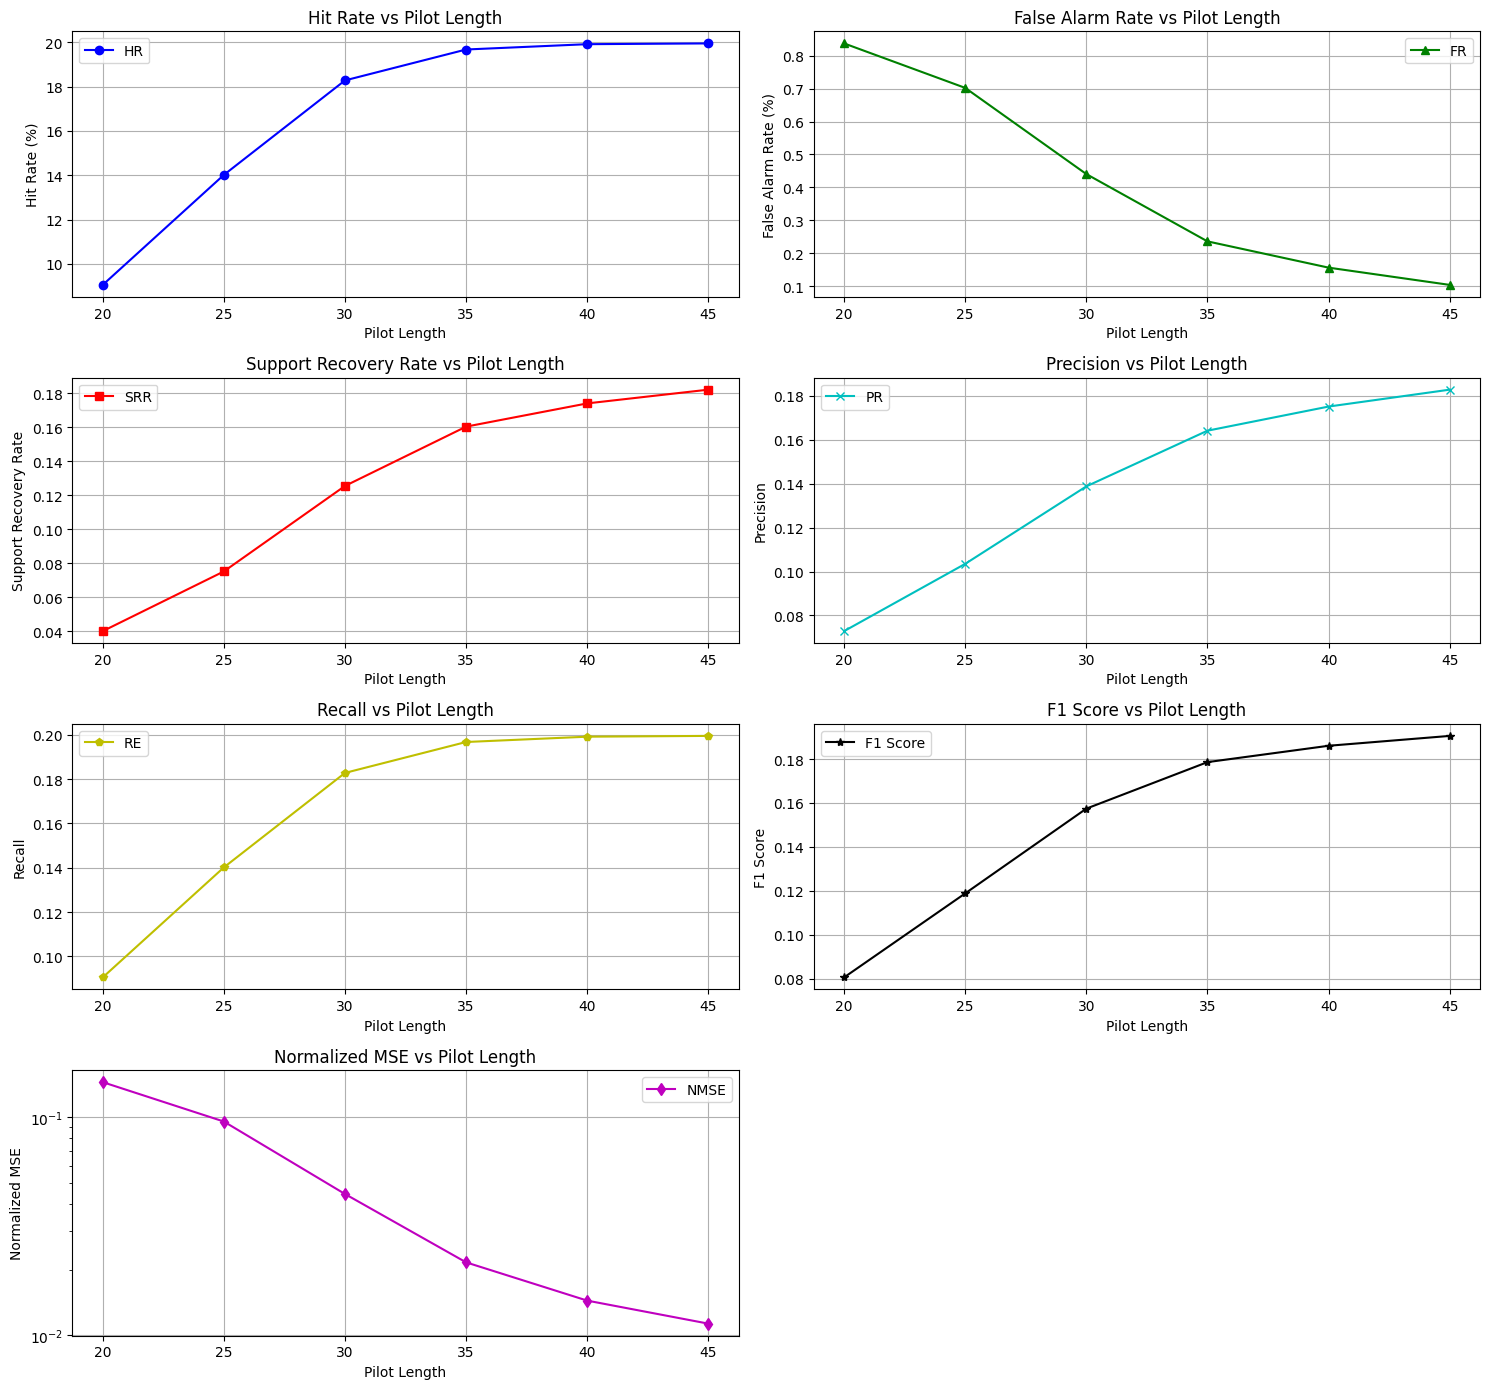

In [9]:
import matplotlib.pyplot as plt

# Define the SNR values for x-axis
pilot_length_values = pilot_length_array

# Create subplots for different performance metrics
plt.figure(figsize=(15, 14))

# Plot Hit Rate (HR)
plt.subplot(4, 2, 1)
plt.plot(pilot_length_values, avg_hr, marker='o', linestyle='-', color='b', label='HR')
plt.xlabel("Pilot Length")
plt.ylabel("Hit Rate (%)")
plt.title("Hit Rate vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot False Alarm Rate (FR)
plt.subplot(4, 2, 2)
plt.plot(pilot_length_values, avg_fr, marker='^', linestyle='-', color='g', label='FR')
plt.xlabel("Pilot Length")
plt.ylabel("False Alarm Rate (%)")
plt.title("False Alarm Rate vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot Support Recovery Rate (SRR)
plt.subplot(4, 2, 3)
plt.plot(pilot_length_values, avg_srr, marker='s', linestyle='-', color='r', label='SRR')
plt.xlabel("Pilot Length")
plt.ylabel("Support Recovery Rate")
plt.title("Support Recovery Rate vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot Precision (PR)
plt.subplot(4, 2, 4)
plt.plot(pilot_length_values, avg_pr, marker='x', linestyle='-', color='c', label='PR')
plt.xlabel("Pilot Length")
plt.ylabel("Precision")
plt.title("Precision vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot Recall (RE)
plt.subplot(4, 2, 5)
plt.plot(pilot_length_values, avg_re, marker='p', linestyle='-', color='y', label='RE')
plt.xlabel("Pilot Length")
plt.ylabel("Recall")
plt.title("Recall vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot F1 Score (F1)
plt.subplot(4, 2, 6)
plt.plot(pilot_length_values, avg_f1, marker='*', linestyle='-', color='k', label='F1 Score')
plt.xlabel("Pilot Length")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot Normalized MSE (NMSE)
plt.subplot(4, 2, 7)
plt.plot(pilot_length_values, avg_nmse, marker='d', linestyle='-', color='m', label='NMSE')
plt.xlabel("Pilot Length")
plt.ylabel("Normalized MSE")
plt.title("Normalized MSE vs Pilot Length")
plt.yscale('log')  # Log scale for better visualization
plt.grid(True)
plt.legend()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_res_vs_ground_truth(sbl_results, Z, sample_index, snr_index, snr_value):
    """Plot sbl reconstructed signal vs ground truth (Z) for a single sample at a given SNR."""
    plt.figure(figsize=(10, 5))

    # Ground truth (Z)
    plt.plot(np.abs(Z[sample_index,:,0]), marker='s', linestyle='--', color='g', label="Ground Truth (Z)")

    # sbl Estimated Signal
    plt.plot(np.abs(sbl_results[sample_index, snr_index, :, 0]), marker='o', linestyle='-', color='b', label="sbl Estimate")

    plt.xlabel("Device Index")
    plt.ylabel("Magnitude of Signal")
    plt.title(f"sbl vs. Ground Truth (Sample {sample_index}, SNR {snr_value} dB)")
    plt.legend()
    plt.grid(True)
    plt.show()

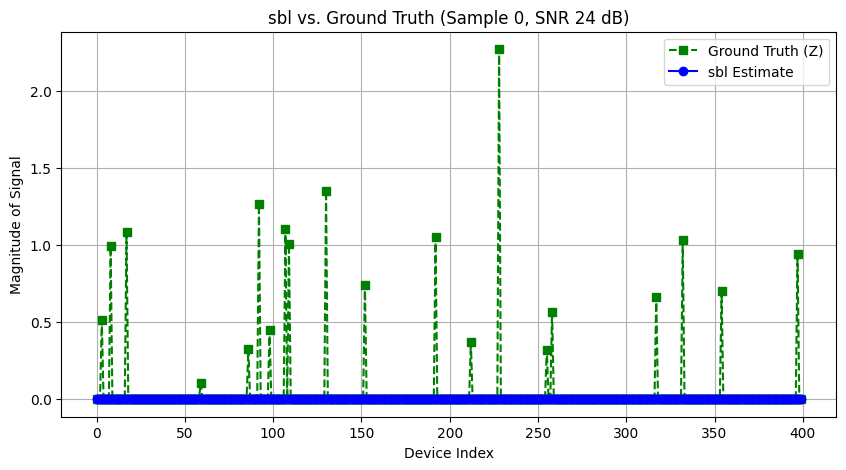

In [11]:
sample_index = 0  # Choose a specific sample
snr_index = 5  # Choose a specific SNR index
snr_value = snr_db_array[snr_index]

plot_res_vs_ground_truth(z_res, all_z, sample_index, snr_index, snr_value)

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def plot_gamma_res_vs_ground_truth(gamma_res, gamma_true, sample_index, snr_index, snr_value):
    """Plot sbl estimated gamma vs ground truth gamma for a single sample at a given SNR."""
    plt.figure(figsize=(10, 5))

    device_indices = np.arange(len(gamma_true[sample_index]))  # X-axis: Device indices

    # Plot ground truth gamma (binary)
    plt.stem(device_indices, gamma_true[sample_index], linefmt='g--', markerfmt='gs', basefmt=" ", label="Ground Truth (γ)")

    # Plot sbl estimated gamma
    plt.stem(device_indices, gamma_res[sample_index, snr_index], linefmt='b-', markerfmt='bo', basefmt=" ", label="sbl Estimate (γ)")

    plt.xlabel("Device Index")
    plt.ylabel("Activity Indicator (0=Inactive, 1=Active)")
    plt.title(f"Device Activity (sbl vs. Ground Truth) - Sample {sample_index}, SNR {snr_value} dB")
    plt.legend()
    plt.grid(True)
    plt.show()


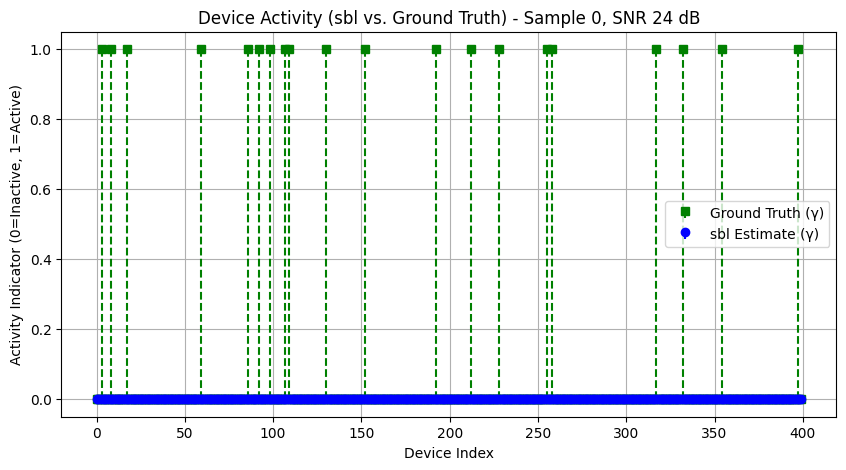

In [13]:
sample_index = 0  # Choose a specific sample
snr_index = 5  # Choose a specific SNR index
snr_value = snr_db_array[snr_index]

plot_gamma_res_vs_ground_truth(gamma_res, all_gamma, sample_index, snr_index, snr_value)